# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

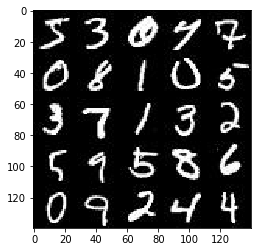

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

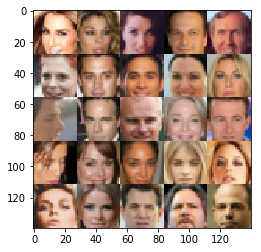

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    with tf.name_scope("input"):
        input_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="image")
        input_noise = tf.placeholder(tf.float32, [None, z_dim], name="noise")
        rate_learn = tf.placeholder(tf.float32, name="learn_rate")

    return input_image, input_noise, rate_learn


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    rate_leak = 0.1
    rate_retain = 0.9
    init_func = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    with tf.variable_scope("discriminator", reuse=reuse):
        conv_0 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=init_func)
        conv_0 = tf.maximum(rate_leak*conv_0, conv_0)
        conv_1 = tf.layers.conv2d(conv_0, 128, 5, strides=2, padding="same", kernel_initializer=init_func)
        conv_1 = tf.layers.batch_normalization(conv_1, training=True)
        conv_1 = tf.maximum(rate_leak*conv_1, conv_1)
        conv_2 = tf.layers.conv2d(conv_1, 256, 5, strides=2, padding="same", kernel_initializer=init_func)
        c2shp = conv_2.get_shape().as_list()
        flat_0 = tf.reshape(conv_2, [-1, c2shp[1]*c2shp[2]*c2shp[3]])
        flat_0 = tf.nn.dropout(flat_0, rate_retain)
        logit = tf.layers.dense(flat_0, 1, kernel_initializer=init_func)
        sigmd = tf.sigmoid(logit)
    return sigmd, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    rate_leak = 0.1
    init_func = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    with tf.variable_scope("generator", reuse=not is_train):
        proj = tf.layers.dense(z, 7*7*512, activation=None, kernel_initializer=init_func)
        ucon_0 = tf.reshape(proj, [-1,7,7,512])
        ucon_0 = tf.layers.batch_normalization(ucon_0, training=is_train)
        ucon_0 = tf.maximum(rate_leak*ucon_0, ucon_0)
        ucon_1 = tf.layers.conv2d_transpose(ucon_0, 256, 5, strides=2, padding="same", kernel_initializer=init_func)
        ucon_1 = tf.layers.batch_normalization(ucon_1, training=is_train)
        ucon_1 = tf.maximum(rate_leak*ucon_1, ucon_1)
        ucon_2 = tf.layers.conv2d_transpose(ucon_1, 128, 5, strides=2, padding="same", kernel_initializer=init_func)
        ucon_2 = tf.layers.batch_normalization(ucon_2, training=is_train)
        ucon_2 = tf.maximum(rate_leak*ucon_2, ucon_2)
        logit = tf.layers.conv2d_transpose(ucon_2, out_channel_dim, 5, strides=1, padding="same", kernel_initializer=init_func)
        image = tf.tanh(logit)
    return image


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    rate_smooth = 0.1
    model_genr = generator(input_z, out_channel_dim)
    model_disc_real, logit_disc_real = discriminator(input_real)
    model_disc_fake, logit_disc_fake = discriminator(model_genr, reuse=True)
    label_real = tf.ones_like(model_disc_fake)
    label_fake = tf.zeros_like(model_disc_fake)
    label_real_disc = tf.scalar_mul(1.0 - rate_smooth, label_real)
    loss_disc_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_disc_real, labels=label_real_disc))
    loss_disc_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_disc_fake, labels=label_fake))
    loss_disc = loss_disc_real + loss_disc_fake
    loss_genr = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_disc_fake, labels=label_real))
    return loss_disc, loss_genr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    vars_all = tf.trainable_variables()
    vars_disc = [v for v in vars_all if v.name.startswith("discriminator")]
    vars_genr = [v for v in vars_all if v.name.startswith("generator")]
    updates_all = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    updates_genr = [op for op in updates_all if op.name.startswith("generator")]
    with tf.control_dependencies(updates_genr):
        trainer_disc = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=vars_disc)
        trainer_genr = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=vars_genr)
    return trainer_disc, trainer_genr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    msg_string = "Epoch {:>3}/{:<3} Batch {:>3} | Loss: Discriminator = {:>3.5f}, Generator = {:>3.5f}"
    input_real, input_z, rate_learn = model_inputs(*data_shape[1:], z_dim)
    loss_disc, loss_genr = model_loss(input_real, input_z, data_shape[-1])
    trainer_disc, trainer_genr = model_opt(loss_disc, loss_genr, rate_learn, beta1)
    batch = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch += 1
                batch_noise = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                batch_images *= 2.0
                sess.run(trainer_disc, feed_dict={input_real: batch_images, input_z: batch_noise, rate_learn: learning_rate})
                sess.run(trainer_genr, feed_dict={input_z: batch_noise, rate_learn: learning_rate})
                sess.run(trainer_genr, feed_dict={input_z: batch_noise, rate_learn: learning_rate})
                if batch % 10 == 0:
                    lossval_disc, lossval_genr = sess.run([loss_disc, loss_genr],
                                                          feed_dict={input_real: batch_images, input_z: batch_noise})
                    print(msg_string.format(epoch_i+1, epoch_count, batch, lossval_disc, lossval_genr))
                if batch % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[-1], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch   1/2   Batch  10 | Loss: Discriminator = 1.20033, Generator = 0.81585
Epoch   1/2   Batch  20 | Loss: Discriminator = 2.99190, Generator = 0.30676
Epoch   1/2   Batch  30 | Loss: Discriminator = 1.79221, Generator = 0.49683
Epoch   1/2   Batch  40 | Loss: Discriminator = 1.92467, Generator = 0.40751
Epoch   1/2   Batch  50 | Loss: Discriminator = 1.83391, Generator = 0.42941
Epoch   1/2   Batch  60 | Loss: Discriminator = 1.85991, Generator = 0.37238
Epoch   1/2   Batch  70 | Loss: Discriminator = 1.89214, Generator = 0.35726
Epoch   1/2   Batch  80 | Loss: Discriminator = 1.78954, Generator = 0.48704
Epoch   1/2   Batch  90 | Loss: Discriminator = 1.77760, Generator = 0.42083
Epoch   1/2   Batch 100 | Loss: Discriminator = 1.74618, Generator = 0.38389


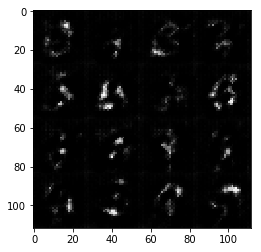

Epoch   1/2   Batch 110 | Loss: Discriminator = 1.88892, Generator = 0.32741
Epoch   1/2   Batch 120 | Loss: Discriminator = 1.82554, Generator = 0.41854
Epoch   1/2   Batch 130 | Loss: Discriminator = 1.48201, Generator = 0.74347
Epoch   1/2   Batch 140 | Loss: Discriminator = 1.84954, Generator = 0.83470
Epoch   1/2   Batch 150 | Loss: Discriminator = 1.44888, Generator = 0.73700
Epoch   1/2   Batch 160 | Loss: Discriminator = 1.63865, Generator = 0.58391
Epoch   1/2   Batch 170 | Loss: Discriminator = 1.51823, Generator = 0.68293
Epoch   1/2   Batch 180 | Loss: Discriminator = 1.51861, Generator = 0.65126
Epoch   1/2   Batch 190 | Loss: Discriminator = 1.61001, Generator = 0.57544
Epoch   1/2   Batch 200 | Loss: Discriminator = 1.39247, Generator = 0.64834


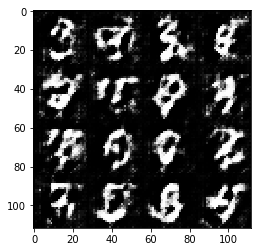

Epoch   1/2   Batch 210 | Loss: Discriminator = 1.38799, Generator = 1.04294
Epoch   1/2   Batch 220 | Loss: Discriminator = 1.45388, Generator = 0.75288
Epoch   1/2   Batch 230 | Loss: Discriminator = 1.83094, Generator = 0.29783
Epoch   1/2   Batch 240 | Loss: Discriminator = 1.49420, Generator = 0.48333
Epoch   1/2   Batch 250 | Loss: Discriminator = 1.38505, Generator = 0.56949
Epoch   1/2   Batch 260 | Loss: Discriminator = 1.66309, Generator = 0.38110
Epoch   1/2   Batch 270 | Loss: Discriminator = 1.90445, Generator = 0.31014
Epoch   1/2   Batch 280 | Loss: Discriminator = 1.88994, Generator = 0.30037
Epoch   1/2   Batch 290 | Loss: Discriminator = 1.56602, Generator = 0.53827
Epoch   1/2   Batch 300 | Loss: Discriminator = 1.46360, Generator = 0.68709


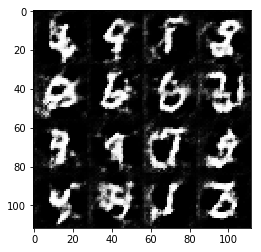

Epoch   1/2   Batch 310 | Loss: Discriminator = 1.46570, Generator = 0.56561
Epoch   1/2   Batch 320 | Loss: Discriminator = 1.50732, Generator = 0.77094
Epoch   1/2   Batch 330 | Loss: Discriminator = 1.53205, Generator = 0.51845
Epoch   1/2   Batch 340 | Loss: Discriminator = 1.61763, Generator = 0.85308
Epoch   1/2   Batch 350 | Loss: Discriminator = 1.37690, Generator = 0.71869
Epoch   1/2   Batch 360 | Loss: Discriminator = 1.82822, Generator = 0.31299
Epoch   1/2   Batch 370 | Loss: Discriminator = 1.48500, Generator = 0.84983
Epoch   1/2   Batch 380 | Loss: Discriminator = 1.37375, Generator = 0.67459
Epoch   1/2   Batch 390 | Loss: Discriminator = 1.59681, Generator = 0.55228
Epoch   1/2   Batch 400 | Loss: Discriminator = 1.78608, Generator = 0.37250


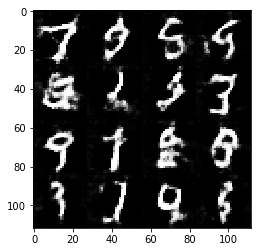

Epoch   1/2   Batch 410 | Loss: Discriminator = 1.55018, Generator = 0.96901
Epoch   1/2   Batch 420 | Loss: Discriminator = 1.45900, Generator = 0.66526
Epoch   1/2   Batch 430 | Loss: Discriminator = 1.56634, Generator = 1.11472
Epoch   1/2   Batch 440 | Loss: Discriminator = 1.56755, Generator = 0.44975
Epoch   1/2   Batch 450 | Loss: Discriminator = 1.39891, Generator = 0.74665
Epoch   1/2   Batch 460 | Loss: Discriminator = 1.65058, Generator = 1.22151
Epoch   1/2   Batch 470 | Loss: Discriminator = 1.56925, Generator = 0.53311
Epoch   1/2   Batch 480 | Loss: Discriminator = 1.57062, Generator = 0.47671
Epoch   1/2   Batch 490 | Loss: Discriminator = 1.47586, Generator = 0.74544
Epoch   1/2   Batch 500 | Loss: Discriminator = 1.46456, Generator = 0.61110


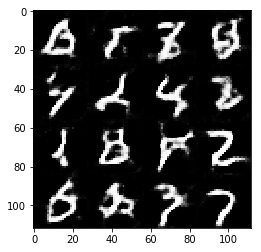

Epoch   1/2   Batch 510 | Loss: Discriminator = 1.55535, Generator = 0.48855
Epoch   1/2   Batch 520 | Loss: Discriminator = 1.54758, Generator = 0.62876
Epoch   1/2   Batch 530 | Loss: Discriminator = 1.44770, Generator = 0.69232
Epoch   1/2   Batch 540 | Loss: Discriminator = 1.48523, Generator = 0.49673
Epoch   1/2   Batch 550 | Loss: Discriminator = 1.62844, Generator = 0.40568
Epoch   1/2   Batch 560 | Loss: Discriminator = 1.43050, Generator = 0.88660
Epoch   1/2   Batch 570 | Loss: Discriminator = 1.79242, Generator = 0.31297
Epoch   1/2   Batch 580 | Loss: Discriminator = 1.37981, Generator = 0.70529
Epoch   1/2   Batch 590 | Loss: Discriminator = 1.55466, Generator = 0.47198
Epoch   1/2   Batch 600 | Loss: Discriminator = 1.49202, Generator = 0.76621


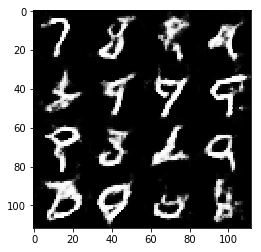

Epoch   1/2   Batch 610 | Loss: Discriminator = 1.57713, Generator = 1.14982
Epoch   1/2   Batch 620 | Loss: Discriminator = 1.40820, Generator = 0.76114
Epoch   1/2   Batch 630 | Loss: Discriminator = 1.43291, Generator = 0.63749
Epoch   1/2   Batch 640 | Loss: Discriminator = 1.56381, Generator = 0.48171
Epoch   1/2   Batch 650 | Loss: Discriminator = 1.43318, Generator = 0.73886
Epoch   1/2   Batch 660 | Loss: Discriminator = 1.93568, Generator = 0.26195
Epoch   1/2   Batch 670 | Loss: Discriminator = 1.46346, Generator = 0.67667
Epoch   1/2   Batch 680 | Loss: Discriminator = 1.57067, Generator = 0.62956
Epoch   1/2   Batch 690 | Loss: Discriminator = 1.53062, Generator = 0.76659
Epoch   1/2   Batch 700 | Loss: Discriminator = 1.42793, Generator = 0.70851


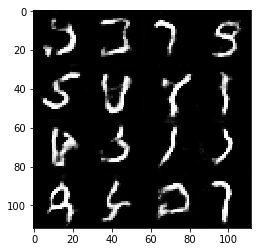

Epoch   1/2   Batch 710 | Loss: Discriminator = 1.58553, Generator = 0.43642
Epoch   1/2   Batch 720 | Loss: Discriminator = 1.58143, Generator = 1.25554
Epoch   1/2   Batch 730 | Loss: Discriminator = 1.44075, Generator = 0.57980
Epoch   1/2   Batch 740 | Loss: Discriminator = 1.30625, Generator = 1.20842
Epoch   1/2   Batch 750 | Loss: Discriminator = 1.55477, Generator = 0.43750
Epoch   1/2   Batch 760 | Loss: Discriminator = 1.37251, Generator = 0.69110
Epoch   1/2   Batch 770 | Loss: Discriminator = 1.54766, Generator = 1.06440
Epoch   1/2   Batch 780 | Loss: Discriminator = 1.53786, Generator = 0.52812
Epoch   1/2   Batch 790 | Loss: Discriminator = 1.44020, Generator = 0.84271
Epoch   1/2   Batch 800 | Loss: Discriminator = 1.45640, Generator = 0.74539


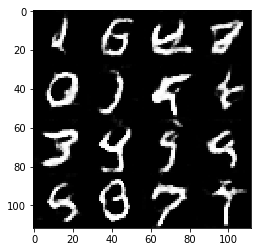

Epoch   1/2   Batch 810 | Loss: Discriminator = 1.35455, Generator = 0.73653
Epoch   1/2   Batch 820 | Loss: Discriminator = 1.52887, Generator = 0.45868
Epoch   1/2   Batch 830 | Loss: Discriminator = 1.39777, Generator = 0.89489
Epoch   1/2   Batch 840 | Loss: Discriminator = 1.24867, Generator = 1.23220
Epoch   1/2   Batch 850 | Loss: Discriminator = 1.43348, Generator = 0.55976
Epoch   1/2   Batch 860 | Loss: Discriminator = 2.20928, Generator = 0.30377
Epoch   1/2   Batch 870 | Loss: Discriminator = 1.69986, Generator = 0.69670
Epoch   1/2   Batch 880 | Loss: Discriminator = 1.34915, Generator = 0.89779
Epoch   1/2   Batch 890 | Loss: Discriminator = 1.35365, Generator = 0.77427
Epoch   1/2   Batch 900 | Loss: Discriminator = 1.29188, Generator = 0.81286


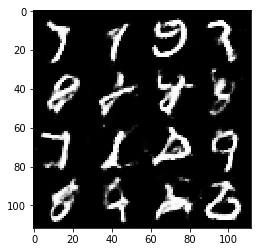

Epoch   1/2   Batch 910 | Loss: Discriminator = 1.45022, Generator = 0.61634
Epoch   1/2   Batch 920 | Loss: Discriminator = 1.46302, Generator = 0.67931
Epoch   1/2   Batch 930 | Loss: Discriminator = 1.41810, Generator = 0.72655
Epoch   2/2   Batch 940 | Loss: Discriminator = 1.33859, Generator = 0.67080
Epoch   2/2   Batch 950 | Loss: Discriminator = 1.45968, Generator = 0.88116
Epoch   2/2   Batch 960 | Loss: Discriminator = 1.66324, Generator = 0.35978
Epoch   2/2   Batch 970 | Loss: Discriminator = 1.50043, Generator = 0.88971
Epoch   2/2   Batch 980 | Loss: Discriminator = 1.40497, Generator = 0.71763
Epoch   2/2   Batch 990 | Loss: Discriminator = 1.41249, Generator = 0.87616
Epoch   2/2   Batch 1000 | Loss: Discriminator = 1.40285, Generator = 0.79199


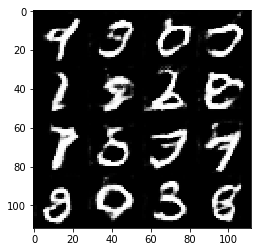

Epoch   2/2   Batch 1010 | Loss: Discriminator = 1.42764, Generator = 0.60815
Epoch   2/2   Batch 1020 | Loss: Discriminator = 1.33239, Generator = 0.78526
Epoch   2/2   Batch 1030 | Loss: Discriminator = 1.29419, Generator = 0.71253
Epoch   2/2   Batch 1040 | Loss: Discriminator = 1.48391, Generator = 0.55306
Epoch   2/2   Batch 1050 | Loss: Discriminator = 1.42749, Generator = 1.23154
Epoch   2/2   Batch 1060 | Loss: Discriminator = 1.53252, Generator = 0.49529
Epoch   2/2   Batch 1070 | Loss: Discriminator = 1.61031, Generator = 0.47154
Epoch   2/2   Batch 1080 | Loss: Discriminator = 1.53085, Generator = 1.04561
Epoch   2/2   Batch 1090 | Loss: Discriminator = 1.53084, Generator = 0.55981
Epoch   2/2   Batch 1100 | Loss: Discriminator = 1.59528, Generator = 0.46368


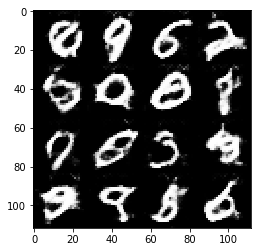

Epoch   2/2   Batch 1110 | Loss: Discriminator = 1.23542, Generator = 1.03649
Epoch   2/2   Batch 1120 | Loss: Discriminator = 1.31288, Generator = 0.77155
Epoch   2/2   Batch 1130 | Loss: Discriminator = 1.35777, Generator = 0.69377
Epoch   2/2   Batch 1140 | Loss: Discriminator = 2.15394, Generator = 0.19417
Epoch   2/2   Batch 1150 | Loss: Discriminator = 1.70811, Generator = 0.45613
Epoch   2/2   Batch 1160 | Loss: Discriminator = 1.43329, Generator = 0.56250
Epoch   2/2   Batch 1170 | Loss: Discriminator = 1.40016, Generator = 0.64547
Epoch   2/2   Batch 1180 | Loss: Discriminator = 1.55716, Generator = 0.45029
Epoch   2/2   Batch 1190 | Loss: Discriminator = 1.62245, Generator = 0.39656
Epoch   2/2   Batch 1200 | Loss: Discriminator = 1.43758, Generator = 0.62864


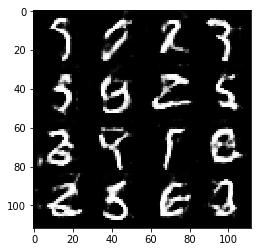

Epoch   2/2   Batch 1210 | Loss: Discriminator = 1.44456, Generator = 0.97925
Epoch   2/2   Batch 1220 | Loss: Discriminator = 1.47590, Generator = 0.86228
Epoch   2/2   Batch 1230 | Loss: Discriminator = 1.54163, Generator = 0.47817
Epoch   2/2   Batch 1240 | Loss: Discriminator = 1.51506, Generator = 0.58249
Epoch   2/2   Batch 1250 | Loss: Discriminator = 1.51430, Generator = 0.86598
Epoch   2/2   Batch 1260 | Loss: Discriminator = 1.39920, Generator = 1.14444
Epoch   2/2   Batch 1270 | Loss: Discriminator = 1.56568, Generator = 0.59410
Epoch   2/2   Batch 1280 | Loss: Discriminator = 1.69512, Generator = 0.36742
Epoch   2/2   Batch 1290 | Loss: Discriminator = 1.33141, Generator = 0.79455
Epoch   2/2   Batch 1300 | Loss: Discriminator = 1.40633, Generator = 1.01223


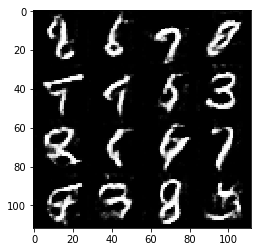

Epoch   2/2   Batch 1310 | Loss: Discriminator = 1.65029, Generator = 0.46219
Epoch   2/2   Batch 1320 | Loss: Discriminator = 1.73134, Generator = 0.93509
Epoch   2/2   Batch 1330 | Loss: Discriminator = 1.44413, Generator = 1.12964
Epoch   2/2   Batch 1340 | Loss: Discriminator = 1.64747, Generator = 0.51338
Epoch   2/2   Batch 1350 | Loss: Discriminator = 1.47129, Generator = 0.66473
Epoch   2/2   Batch 1360 | Loss: Discriminator = 1.49456, Generator = 0.55767
Epoch   2/2   Batch 1370 | Loss: Discriminator = 1.44108, Generator = 0.54014
Epoch   2/2   Batch 1380 | Loss: Discriminator = 1.33887, Generator = 0.85709
Epoch   2/2   Batch 1390 | Loss: Discriminator = 1.49356, Generator = 0.47439
Epoch   2/2   Batch 1400 | Loss: Discriminator = 2.43541, Generator = 2.12801


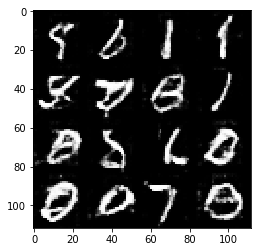

Epoch   2/2   Batch 1410 | Loss: Discriminator = 1.28336, Generator = 0.84797
Epoch   2/2   Batch 1420 | Loss: Discriminator = 1.42076, Generator = 0.67383
Epoch   2/2   Batch 1430 | Loss: Discriminator = 1.44311, Generator = 0.64075
Epoch   2/2   Batch 1440 | Loss: Discriminator = 1.37828, Generator = 0.63735
Epoch   2/2   Batch 1450 | Loss: Discriminator = 1.41268, Generator = 0.67345
Epoch   2/2   Batch 1460 | Loss: Discriminator = 1.43432, Generator = 0.51307
Epoch   2/2   Batch 1470 | Loss: Discriminator = 1.41997, Generator = 0.64204
Epoch   2/2   Batch 1480 | Loss: Discriminator = 1.39305, Generator = 0.87493
Epoch   2/2   Batch 1490 | Loss: Discriminator = 1.46932, Generator = 0.54218
Epoch   2/2   Batch 1500 | Loss: Discriminator = 1.47330, Generator = 0.52526


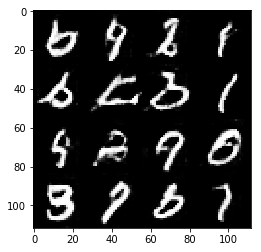

Epoch   2/2   Batch 1510 | Loss: Discriminator = 1.45188, Generator = 0.63213
Epoch   2/2   Batch 1520 | Loss: Discriminator = 1.40508, Generator = 0.79218
Epoch   2/2   Batch 1530 | Loss: Discriminator = 1.29693, Generator = 0.77875
Epoch   2/2   Batch 1540 | Loss: Discriminator = 1.41822, Generator = 0.73032
Epoch   2/2   Batch 1550 | Loss: Discriminator = 1.46308, Generator = 0.53953
Epoch   2/2   Batch 1560 | Loss: Discriminator = 1.45833, Generator = 0.75867
Epoch   2/2   Batch 1570 | Loss: Discriminator = 1.51659, Generator = 0.57083
Epoch   2/2   Batch 1580 | Loss: Discriminator = 1.97602, Generator = 0.25178
Epoch   2/2   Batch 1590 | Loss: Discriminator = 1.69309, Generator = 0.42879
Epoch   2/2   Batch 1600 | Loss: Discriminator = 1.36265, Generator = 0.71926


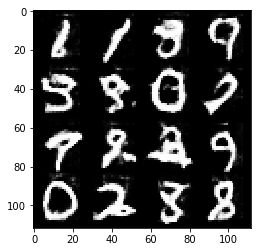

Epoch   2/2   Batch 1610 | Loss: Discriminator = 1.48671, Generator = 0.64094
Epoch   2/2   Batch 1620 | Loss: Discriminator = 1.38365, Generator = 0.92574
Epoch   2/2   Batch 1630 | Loss: Discriminator = 1.46577, Generator = 0.58475
Epoch   2/2   Batch 1640 | Loss: Discriminator = 1.45053, Generator = 0.57495
Epoch   2/2   Batch 1650 | Loss: Discriminator = 1.82712, Generator = 0.30392
Epoch   2/2   Batch 1660 | Loss: Discriminator = 1.37791, Generator = 0.85137
Epoch   2/2   Batch 1670 | Loss: Discriminator = 1.36648, Generator = 0.68463
Epoch   2/2   Batch 1680 | Loss: Discriminator = 1.40842, Generator = 1.08016
Epoch   2/2   Batch 1690 | Loss: Discriminator = 1.48825, Generator = 0.50400
Epoch   2/2   Batch 1700 | Loss: Discriminator = 1.65076, Generator = 0.37031


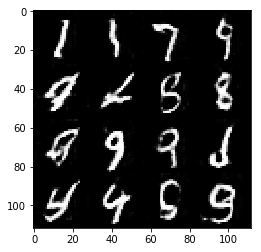

Epoch   2/2   Batch 1710 | Loss: Discriminator = 1.87094, Generator = 0.32603
Epoch   2/2   Batch 1720 | Loss: Discriminator = 1.77726, Generator = 0.49719
Epoch   2/2   Batch 1730 | Loss: Discriminator = 1.56323, Generator = 0.51696
Epoch   2/2   Batch 1740 | Loss: Discriminator = 1.50728, Generator = 0.60096
Epoch   2/2   Batch 1750 | Loss: Discriminator = 1.36440, Generator = 0.70098
Epoch   2/2   Batch 1760 | Loss: Discriminator = 1.32434, Generator = 0.79877
Epoch   2/2   Batch 1770 | Loss: Discriminator = 1.48562, Generator = 0.58043
Epoch   2/2   Batch 1780 | Loss: Discriminator = 1.60386, Generator = 0.45620
Epoch   2/2   Batch 1790 | Loss: Discriminator = 1.31623, Generator = 0.63399
Epoch   2/2   Batch 1800 | Loss: Discriminator = 1.79203, Generator = 0.37686


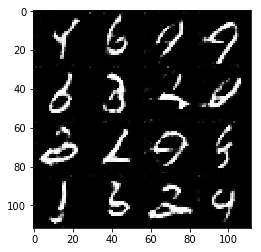

Epoch   2/2   Batch 1810 | Loss: Discriminator = 1.41077, Generator = 0.59225
Epoch   2/2   Batch 1820 | Loss: Discriminator = 1.43027, Generator = 0.64143
Epoch   2/2   Batch 1830 | Loss: Discriminator = 1.45044, Generator = 0.64349
Epoch   2/2   Batch 1840 | Loss: Discriminator = 1.45918, Generator = 0.58387
Epoch   2/2   Batch 1850 | Loss: Discriminator = 1.42081, Generator = 0.96409
Epoch   2/2   Batch 1860 | Loss: Discriminator = 1.42075, Generator = 0.75246
Epoch   2/2   Batch 1870 | Loss: Discriminator = 1.30727, Generator = 0.77971


In [21]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch   1/1   Batch  10 | Loss: Discriminator = 2.70184, Generator = 0.19463
Epoch   1/1   Batch  20 | Loss: Discriminator = 3.36100, Generator = 0.09788
Epoch   1/1   Batch  30 | Loss: Discriminator = 2.01407, Generator = 0.61755
Epoch   1/1   Batch  40 | Loss: Discriminator = 1.89320, Generator = 1.09800
Epoch   1/1   Batch  50 | Loss: Discriminator = 1.34536, Generator = 1.47351
Epoch   1/1   Batch  60 | Loss: Discriminator = 1.86466, Generator = 0.80406
Epoch   1/1   Batch  70 | Loss: Discriminator = 1.38262, Generator = 1.46632
Epoch   1/1   Batch  80 | Loss: Discriminator = 1.60193, Generator = 0.51601
Epoch   1/1   Batch  90 | Loss: Discriminator = 1.96785, Generator = 0.43720
Epoch   1/1   Batch 100 | Loss: Discriminator = 1.64632, Generator = 0.63624


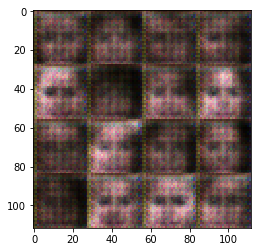

Epoch   1/1   Batch 110 | Loss: Discriminator = 1.46539, Generator = 0.84648
Epoch   1/1   Batch 120 | Loss: Discriminator = 2.07275, Generator = 0.32036
Epoch   1/1   Batch 130 | Loss: Discriminator = 1.63324, Generator = 0.58384
Epoch   1/1   Batch 140 | Loss: Discriminator = 1.33848, Generator = 0.68680
Epoch   1/1   Batch 150 | Loss: Discriminator = 1.23963, Generator = 0.89478
Epoch   1/1   Batch 160 | Loss: Discriminator = 1.27249, Generator = 0.66711
Epoch   1/1   Batch 170 | Loss: Discriminator = 1.08049, Generator = 1.39425
Epoch   1/1   Batch 180 | Loss: Discriminator = 1.45578, Generator = 0.71674
Epoch   1/1   Batch 190 | Loss: Discriminator = 1.57856, Generator = 0.52638
Epoch   1/1   Batch 200 | Loss: Discriminator = 1.85076, Generator = 0.49999


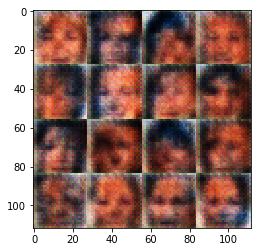

Epoch   1/1   Batch 210 | Loss: Discriminator = 0.84599, Generator = 2.30046
Epoch   1/1   Batch 220 | Loss: Discriminator = 1.17900, Generator = 1.27637
Epoch   1/1   Batch 230 | Loss: Discriminator = 1.42973, Generator = 0.77494
Epoch   1/1   Batch 240 | Loss: Discriminator = 1.49905, Generator = 0.56800
Epoch   1/1   Batch 250 | Loss: Discriminator = 1.31631, Generator = 0.59861
Epoch   1/1   Batch 260 | Loss: Discriminator = 1.46680, Generator = 0.63550
Epoch   1/1   Batch 270 | Loss: Discriminator = 1.56426, Generator = 0.51246
Epoch   1/1   Batch 280 | Loss: Discriminator = 1.45002, Generator = 0.65178
Epoch   1/1   Batch 290 | Loss: Discriminator = 1.44189, Generator = 0.80661
Epoch   1/1   Batch 300 | Loss: Discriminator = 1.39568, Generator = 0.71797


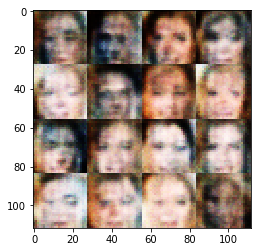

Epoch   1/1   Batch 310 | Loss: Discriminator = 1.29073, Generator = 0.81248
Epoch   1/1   Batch 320 | Loss: Discriminator = 1.30772, Generator = 0.65416
Epoch   1/1   Batch 330 | Loss: Discriminator = 1.23894, Generator = 0.65806
Epoch   1/1   Batch 340 | Loss: Discriminator = 1.57345, Generator = 0.43737
Epoch   1/1   Batch 350 | Loss: Discriminator = 1.35552, Generator = 0.72528
Epoch   1/1   Batch 360 | Loss: Discriminator = 1.88376, Generator = 0.33483
Epoch   1/1   Batch 370 | Loss: Discriminator = 1.58988, Generator = 0.64761
Epoch   1/1   Batch 380 | Loss: Discriminator = 1.71404, Generator = 0.36209
Epoch   1/1   Batch 390 | Loss: Discriminator = 0.86816, Generator = 1.60031
Epoch   1/1   Batch 400 | Loss: Discriminator = 1.13193, Generator = 1.25615


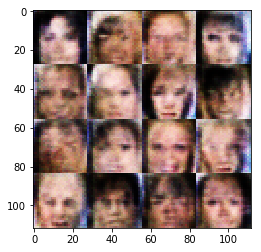

Epoch   1/1   Batch 410 | Loss: Discriminator = 0.96458, Generator = 1.20289
Epoch   1/1   Batch 420 | Loss: Discriminator = 1.34923, Generator = 0.57789
Epoch   1/1   Batch 430 | Loss: Discriminator = 1.32343, Generator = 0.63336
Epoch   1/1   Batch 440 | Loss: Discriminator = 0.96836, Generator = 1.64875
Epoch   1/1   Batch 450 | Loss: Discriminator = 0.76043, Generator = 2.04459
Epoch   1/1   Batch 460 | Loss: Discriminator = 1.16545, Generator = 4.42440
Epoch   1/1   Batch 470 | Loss: Discriminator = 1.07208, Generator = 1.24401
Epoch   1/1   Batch 480 | Loss: Discriminator = 0.88158, Generator = 1.51138
Epoch   1/1   Batch 490 | Loss: Discriminator = 1.02229, Generator = 1.05285
Epoch   1/1   Batch 500 | Loss: Discriminator = 0.97154, Generator = 1.60607


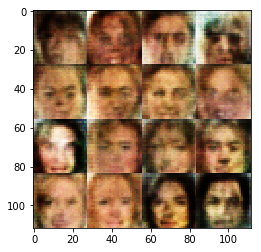

Epoch   1/1   Batch 510 | Loss: Discriminator = 1.19199, Generator = 0.94074
Epoch   1/1   Batch 520 | Loss: Discriminator = 1.50887, Generator = 0.65488
Epoch   1/1   Batch 530 | Loss: Discriminator = 1.58307, Generator = 0.58606
Epoch   1/1   Batch 540 | Loss: Discriminator = 1.51837, Generator = 0.78652
Epoch   1/1   Batch 550 | Loss: Discriminator = 1.37832, Generator = 0.85298
Epoch   1/1   Batch 560 | Loss: Discriminator = 1.56505, Generator = 0.50201
Epoch   1/1   Batch 570 | Loss: Discriminator = 1.41789, Generator = 0.71046
Epoch   1/1   Batch 580 | Loss: Discriminator = 1.15254, Generator = 1.40944
Epoch   1/1   Batch 590 | Loss: Discriminator = 1.07677, Generator = 1.48652
Epoch   1/1   Batch 600 | Loss: Discriminator = 1.33975, Generator = 0.93748


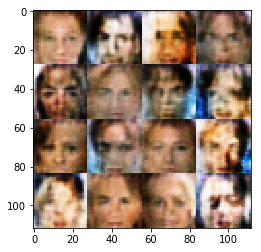

Epoch   1/1   Batch 610 | Loss: Discriminator = 1.48879, Generator = 0.69575
Epoch   1/1   Batch 620 | Loss: Discriminator = 1.50168, Generator = 0.60387
Epoch   1/1   Batch 630 | Loss: Discriminator = 1.50869, Generator = 0.61417
Epoch   1/1   Batch 640 | Loss: Discriminator = 1.10509, Generator = 1.39373
Epoch   1/1   Batch 650 | Loss: Discriminator = 1.18436, Generator = 1.03222
Epoch   1/1   Batch 660 | Loss: Discriminator = 1.40397, Generator = 0.78247
Epoch   1/1   Batch 670 | Loss: Discriminator = 1.48602, Generator = 0.64167
Epoch   1/1   Batch 680 | Loss: Discriminator = 1.41854, Generator = 0.74998
Epoch   1/1   Batch 690 | Loss: Discriminator = 1.47372, Generator = 0.60948
Epoch   1/1   Batch 700 | Loss: Discriminator = 1.53651, Generator = 0.73841


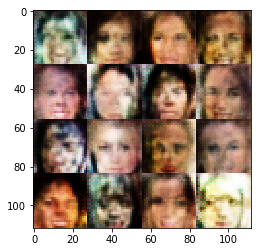

Epoch   1/1   Batch 710 | Loss: Discriminator = 1.49225, Generator = 0.68162
Epoch   1/1   Batch 720 | Loss: Discriminator = 1.53188, Generator = 0.58361
Epoch   1/1   Batch 730 | Loss: Discriminator = 1.52699, Generator = 0.65733
Epoch   1/1   Batch 740 | Loss: Discriminator = 1.48379, Generator = 0.55076
Epoch   1/1   Batch 750 | Loss: Discriminator = 1.45955, Generator = 0.63222
Epoch   1/1   Batch 760 | Loss: Discriminator = 1.47885, Generator = 0.60783
Epoch   1/1   Batch 770 | Loss: Discriminator = 1.23204, Generator = 1.15963
Epoch   1/1   Batch 780 | Loss: Discriminator = 1.16015, Generator = 1.24008
Epoch   1/1   Batch 790 | Loss: Discriminator = 1.51118, Generator = 0.65749
Epoch   1/1   Batch 800 | Loss: Discriminator = 1.50350, Generator = 0.83526


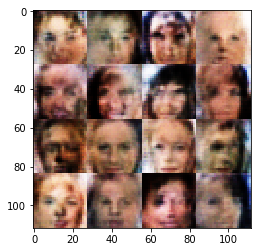

Epoch   1/1   Batch 810 | Loss: Discriminator = 1.47323, Generator = 0.67148
Epoch   1/1   Batch 820 | Loss: Discriminator = 1.45301, Generator = 0.77032
Epoch   1/1   Batch 830 | Loss: Discriminator = 0.98910, Generator = 1.91582
Epoch   1/1   Batch 840 | Loss: Discriminator = 1.21693, Generator = 0.97898
Epoch   1/1   Batch 850 | Loss: Discriminator = 1.48900, Generator = 0.74080
Epoch   1/1   Batch 860 | Loss: Discriminator = 1.50672, Generator = 0.80163
Epoch   1/1   Batch 870 | Loss: Discriminator = 1.52501, Generator = 0.61919
Epoch   1/1   Batch 880 | Loss: Discriminator = 1.31583, Generator = 0.85985
Epoch   1/1   Batch 890 | Loss: Discriminator = 1.34656, Generator = 0.94394
Epoch   1/1   Batch 900 | Loss: Discriminator = 1.35787, Generator = 0.80857


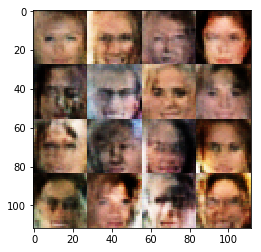

Epoch   1/1   Batch 910 | Loss: Discriminator = 1.30957, Generator = 0.79005
Epoch   1/1   Batch 920 | Loss: Discriminator = 1.41972, Generator = 0.68075
Epoch   1/1   Batch 930 | Loss: Discriminator = 1.46244, Generator = 0.77936
Epoch   1/1   Batch 940 | Loss: Discriminator = 1.44350, Generator = 0.69758
Epoch   1/1   Batch 950 | Loss: Discriminator = 1.40027, Generator = 0.84662
Epoch   1/1   Batch 960 | Loss: Discriminator = 1.19061, Generator = 1.03145
Epoch   1/1   Batch 970 | Loss: Discriminator = 1.27107, Generator = 1.01431
Epoch   1/1   Batch 980 | Loss: Discriminator = 1.34458, Generator = 0.92148
Epoch   1/1   Batch 990 | Loss: Discriminator = 1.53018, Generator = 0.62476
Epoch   1/1   Batch 1000 | Loss: Discriminator = 1.37385, Generator = 0.87526


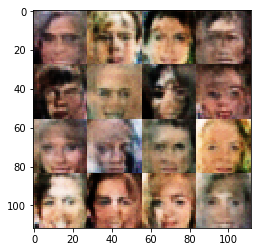

Epoch   1/1   Batch 1010 | Loss: Discriminator = 1.43659, Generator = 0.64364
Epoch   1/1   Batch 1020 | Loss: Discriminator = 1.50180, Generator = 0.65380
Epoch   1/1   Batch 1030 | Loss: Discriminator = 1.40923, Generator = 0.70895
Epoch   1/1   Batch 1040 | Loss: Discriminator = 1.45641, Generator = 0.64167
Epoch   1/1   Batch 1050 | Loss: Discriminator = 1.18194, Generator = 1.15864
Epoch   1/1   Batch 1060 | Loss: Discriminator = 1.34634, Generator = 0.82489
Epoch   1/1   Batch 1070 | Loss: Discriminator = 1.48157, Generator = 0.63376
Epoch   1/1   Batch 1080 | Loss: Discriminator = 1.30509, Generator = 0.84531
Epoch   1/1   Batch 1090 | Loss: Discriminator = 1.46936, Generator = 0.58823
Epoch   1/1   Batch 1100 | Loss: Discriminator = 1.49356, Generator = 0.66956


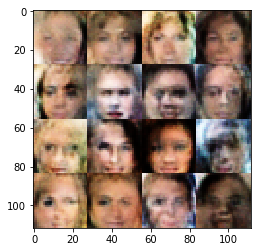

Epoch   1/1   Batch 1110 | Loss: Discriminator = 1.35605, Generator = 0.94834
Epoch   1/1   Batch 1120 | Loss: Discriminator = 1.41579, Generator = 0.74472
Epoch   1/1   Batch 1130 | Loss: Discriminator = 1.52201, Generator = 0.52749
Epoch   1/1   Batch 1140 | Loss: Discriminator = 1.45312, Generator = 0.71282
Epoch   1/1   Batch 1150 | Loss: Discriminator = 1.48818, Generator = 0.67883
Epoch   1/1   Batch 1160 | Loss: Discriminator = 1.46042, Generator = 0.66605
Epoch   1/1   Batch 1170 | Loss: Discriminator = 1.47136, Generator = 0.83826
Epoch   1/1   Batch 1180 | Loss: Discriminator = 1.42174, Generator = 0.57716
Epoch   1/1   Batch 1190 | Loss: Discriminator = 1.48245, Generator = 0.64870
Epoch   1/1   Batch 1200 | Loss: Discriminator = 1.47973, Generator = 0.59408


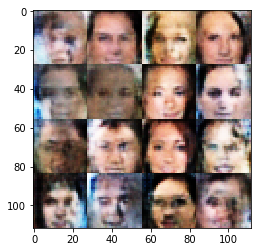

Epoch   1/1   Batch 1210 | Loss: Discriminator = 1.50363, Generator = 0.69284
Epoch   1/1   Batch 1220 | Loss: Discriminator = 1.45418, Generator = 0.74553
Epoch   1/1   Batch 1230 | Loss: Discriminator = 1.47102, Generator = 0.59584
Epoch   1/1   Batch 1240 | Loss: Discriminator = 1.49248, Generator = 0.62261
Epoch   1/1   Batch 1250 | Loss: Discriminator = 1.45881, Generator = 0.80462
Epoch   1/1   Batch 1260 | Loss: Discriminator = 1.36933, Generator = 0.76784
Epoch   1/1   Batch 1270 | Loss: Discriminator = 1.50974, Generator = 0.64950
Epoch   1/1   Batch 1280 | Loss: Discriminator = 1.46491, Generator = 0.73642
Epoch   1/1   Batch 1290 | Loss: Discriminator = 1.26402, Generator = 0.91320
Epoch   1/1   Batch 1300 | Loss: Discriminator = 1.51401, Generator = 0.81191


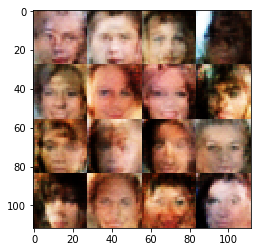

Epoch   1/1   Batch 1310 | Loss: Discriminator = 1.41142, Generator = 0.67401
Epoch   1/1   Batch 1320 | Loss: Discriminator = 1.46898, Generator = 0.68792
Epoch   1/1   Batch 1330 | Loss: Discriminator = 1.22468, Generator = 1.27559
Epoch   1/1   Batch 1340 | Loss: Discriminator = 1.51125, Generator = 0.58562
Epoch   1/1   Batch 1350 | Loss: Discriminator = 1.52618, Generator = 0.50566
Epoch   1/1   Batch 1360 | Loss: Discriminator = 1.46049, Generator = 0.63314
Epoch   1/1   Batch 1370 | Loss: Discriminator = 1.46261, Generator = 0.62824
Epoch   1/1   Batch 1380 | Loss: Discriminator = 1.42536, Generator = 0.70890
Epoch   1/1   Batch 1390 | Loss: Discriminator = 1.58188, Generator = 0.56579
Epoch   1/1   Batch 1400 | Loss: Discriminator = 1.29238, Generator = 1.12357


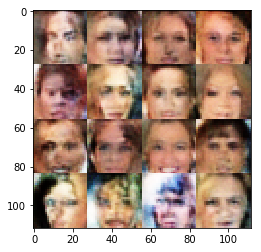

Epoch   1/1   Batch 1410 | Loss: Discriminator = 1.49272, Generator = 0.60141
Epoch   1/1   Batch 1420 | Loss: Discriminator = 1.46257, Generator = 0.54276
Epoch   1/1   Batch 1430 | Loss: Discriminator = 1.43805, Generator = 0.70834
Epoch   1/1   Batch 1440 | Loss: Discriminator = 1.43971, Generator = 0.65075
Epoch   1/1   Batch 1450 | Loss: Discriminator = 1.39431, Generator = 0.74077
Epoch   1/1   Batch 1460 | Loss: Discriminator = 1.26562, Generator = 1.09062
Epoch   1/1   Batch 1470 | Loss: Discriminator = 1.47923, Generator = 0.68053
Epoch   1/1   Batch 1480 | Loss: Discriminator = 1.51566, Generator = 0.54221
Epoch   1/1   Batch 1490 | Loss: Discriminator = 1.47542, Generator = 0.81525
Epoch   1/1   Batch 1500 | Loss: Discriminator = 1.51103, Generator = 0.59061


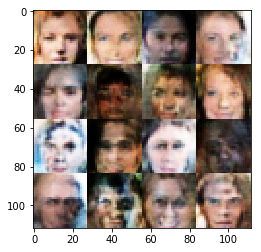

Epoch   1/1   Batch 1510 | Loss: Discriminator = 1.37546, Generator = 0.72740
Epoch   1/1   Batch 1520 | Loss: Discriminator = 1.39203, Generator = 0.73113
Epoch   1/1   Batch 1530 | Loss: Discriminator = 1.43607, Generator = 0.61941
Epoch   1/1   Batch 1540 | Loss: Discriminator = 1.43674, Generator = 0.72202
Epoch   1/1   Batch 1550 | Loss: Discriminator = 1.53517, Generator = 0.62479
Epoch   1/1   Batch 1560 | Loss: Discriminator = 1.47429, Generator = 0.78815
Epoch   1/1   Batch 1570 | Loss: Discriminator = 1.40975, Generator = 0.79786
Epoch   1/1   Batch 1580 | Loss: Discriminator = 1.43076, Generator = 0.68598
Epoch   1/1   Batch 1590 | Loss: Discriminator = 1.48804, Generator = 0.59812
Epoch   1/1   Batch 1600 | Loss: Discriminator = 1.41513, Generator = 0.74740


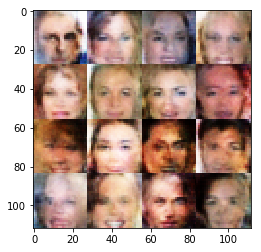

Epoch   1/1   Batch 1610 | Loss: Discriminator = 1.43054, Generator = 0.73168
Epoch   1/1   Batch 1620 | Loss: Discriminator = 1.51896, Generator = 0.62656
Epoch   1/1   Batch 1630 | Loss: Discriminator = 1.53510, Generator = 0.67108
Epoch   1/1   Batch 1640 | Loss: Discriminator = 1.57922, Generator = 0.63862
Epoch   1/1   Batch 1650 | Loss: Discriminator = 1.44506, Generator = 0.68712
Epoch   1/1   Batch 1660 | Loss: Discriminator = 1.54193, Generator = 0.71157
Epoch   1/1   Batch 1670 | Loss: Discriminator = 1.50430, Generator = 0.57774
Epoch   1/1   Batch 1680 | Loss: Discriminator = 1.48443, Generator = 0.75814
Epoch   1/1   Batch 1690 | Loss: Discriminator = 1.51742, Generator = 0.57488
Epoch   1/1   Batch 1700 | Loss: Discriminator = 1.47323, Generator = 0.64408


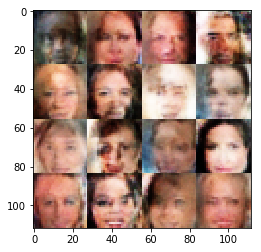

Epoch   1/1   Batch 1710 | Loss: Discriminator = 1.40680, Generator = 0.76413
Epoch   1/1   Batch 1720 | Loss: Discriminator = 1.48511, Generator = 0.58009
Epoch   1/1   Batch 1730 | Loss: Discriminator = 1.47331, Generator = 0.59976
Epoch   1/1   Batch 1740 | Loss: Discriminator = 1.53773, Generator = 0.61858
Epoch   1/1   Batch 1750 | Loss: Discriminator = 1.50950, Generator = 0.65519
Epoch   1/1   Batch 1760 | Loss: Discriminator = 1.49957, Generator = 0.67282
Epoch   1/1   Batch 1770 | Loss: Discriminator = 1.53675, Generator = 0.61075
Epoch   1/1   Batch 1780 | Loss: Discriminator = 1.49500, Generator = 0.61435
Epoch   1/1   Batch 1790 | Loss: Discriminator = 1.54165, Generator = 0.51658
Epoch   1/1   Batch 1800 | Loss: Discriminator = 1.51809, Generator = 0.53292


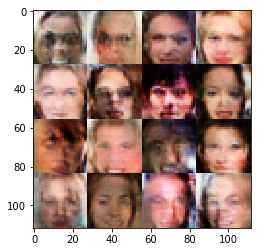

Epoch   1/1   Batch 1810 | Loss: Discriminator = 1.46349, Generator = 0.75362
Epoch   1/1   Batch 1820 | Loss: Discriminator = 1.43572, Generator = 0.73558
Epoch   1/1   Batch 1830 | Loss: Discriminator = 1.41842, Generator = 0.69262
Epoch   1/1   Batch 1840 | Loss: Discriminator = 1.47279, Generator = 0.68042
Epoch   1/1   Batch 1850 | Loss: Discriminator = 1.52895, Generator = 0.61742
Epoch   1/1   Batch 1860 | Loss: Discriminator = 1.52873, Generator = 0.77115
Epoch   1/1   Batch 1870 | Loss: Discriminator = 1.37638, Generator = 0.77900
Epoch   1/1   Batch 1880 | Loss: Discriminator = 1.51411, Generator = 0.61526
Epoch   1/1   Batch 1890 | Loss: Discriminator = 1.39394, Generator = 0.85675
Epoch   1/1   Batch 1900 | Loss: Discriminator = 1.48062, Generator = 0.67591


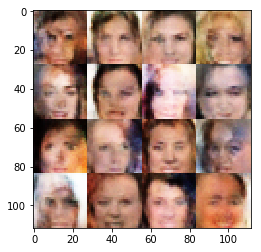

Epoch   1/1   Batch 1910 | Loss: Discriminator = 1.54801, Generator = 0.57087
Epoch   1/1   Batch 1920 | Loss: Discriminator = 1.49525, Generator = 0.60241
Epoch   1/1   Batch 1930 | Loss: Discriminator = 1.49276, Generator = 0.68832
Epoch   1/1   Batch 1940 | Loss: Discriminator = 1.40739, Generator = 0.64083
Epoch   1/1   Batch 1950 | Loss: Discriminator = 1.51891, Generator = 0.64892
Epoch   1/1   Batch 1960 | Loss: Discriminator = 1.51852, Generator = 0.69930
Epoch   1/1   Batch 1970 | Loss: Discriminator = 1.45867, Generator = 0.61223
Epoch   1/1   Batch 1980 | Loss: Discriminator = 1.48139, Generator = 0.75523
Epoch   1/1   Batch 1990 | Loss: Discriminator = 1.50133, Generator = 0.63796
Epoch   1/1   Batch 2000 | Loss: Discriminator = 1.48891, Generator = 0.68679


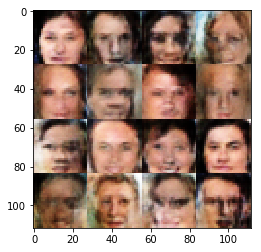

Epoch   1/1   Batch 2010 | Loss: Discriminator = 1.47153, Generator = 0.66350
Epoch   1/1   Batch 2020 | Loss: Discriminator = 1.46410, Generator = 0.65105
Epoch   1/1   Batch 2030 | Loss: Discriminator = 1.60600, Generator = 0.48973
Epoch   1/1   Batch 2040 | Loss: Discriminator = 1.44801, Generator = 0.71621
Epoch   1/1   Batch 2050 | Loss: Discriminator = 1.38377, Generator = 0.70699
Epoch   1/1   Batch 2060 | Loss: Discriminator = 1.54147, Generator = 0.67245
Epoch   1/1   Batch 2070 | Loss: Discriminator = 1.61178, Generator = 0.57847
Epoch   1/1   Batch 2080 | Loss: Discriminator = 1.44667, Generator = 0.65122
Epoch   1/1   Batch 2090 | Loss: Discriminator = 1.49388, Generator = 0.61487
Epoch   1/1   Batch 2100 | Loss: Discriminator = 1.50353, Generator = 0.65960


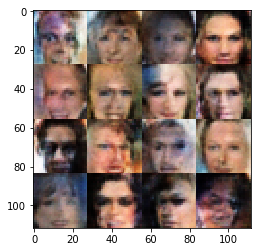

Epoch   1/1   Batch 2110 | Loss: Discriminator = 1.50064, Generator = 0.64198
Epoch   1/1   Batch 2120 | Loss: Discriminator = 1.43670, Generator = 0.71661
Epoch   1/1   Batch 2130 | Loss: Discriminator = 1.52094, Generator = 0.58796
Epoch   1/1   Batch 2140 | Loss: Discriminator = 1.43361, Generator = 0.62468
Epoch   1/1   Batch 2150 | Loss: Discriminator = 1.47187, Generator = 0.63017
Epoch   1/1   Batch 2160 | Loss: Discriminator = 1.53265, Generator = 0.57574
Epoch   1/1   Batch 2170 | Loss: Discriminator = 1.48743, Generator = 0.68070
Epoch   1/1   Batch 2180 | Loss: Discriminator = 1.53267, Generator = 0.63574
Epoch   1/1   Batch 2190 | Loss: Discriminator = 1.50806, Generator = 0.62057
Epoch   1/1   Batch 2200 | Loss: Discriminator = 1.48040, Generator = 0.70410


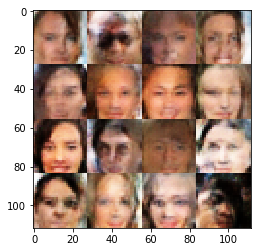

Epoch   1/1   Batch 2210 | Loss: Discriminator = 1.56350, Generator = 0.57639
Epoch   1/1   Batch 2220 | Loss: Discriminator = 1.44654, Generator = 0.73506
Epoch   1/1   Batch 2230 | Loss: Discriminator = 1.47961, Generator = 0.65317
Epoch   1/1   Batch 2240 | Loss: Discriminator = 1.50491, Generator = 0.63905
Epoch   1/1   Batch 2250 | Loss: Discriminator = 1.53780, Generator = 0.58970
Epoch   1/1   Batch 2260 | Loss: Discriminator = 1.44821, Generator = 0.72694
Epoch   1/1   Batch 2270 | Loss: Discriminator = 1.47820, Generator = 0.70847
Epoch   1/1   Batch 2280 | Loss: Discriminator = 1.53780, Generator = 0.65628
Epoch   1/1   Batch 2290 | Loss: Discriminator = 1.37787, Generator = 0.81282
Epoch   1/1   Batch 2300 | Loss: Discriminator = 1.43342, Generator = 0.74650


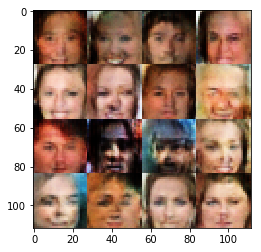

Epoch   1/1   Batch 2310 | Loss: Discriminator = 1.44612, Generator = 0.71541
Epoch   1/1   Batch 2320 | Loss: Discriminator = 1.47626, Generator = 0.67006
Epoch   1/1   Batch 2330 | Loss: Discriminator = 1.43484, Generator = 0.68041
Epoch   1/1   Batch 2340 | Loss: Discriminator = 1.48628, Generator = 0.63451
Epoch   1/1   Batch 2350 | Loss: Discriminator = 1.49613, Generator = 0.67110
Epoch   1/1   Batch 2360 | Loss: Discriminator = 1.52344, Generator = 0.59728
Epoch   1/1   Batch 2370 | Loss: Discriminator = 1.55542, Generator = 0.62345
Epoch   1/1   Batch 2380 | Loss: Discriminator = 1.50609, Generator = 0.78332
Epoch   1/1   Batch 2390 | Loss: Discriminator = 1.46601, Generator = 0.61035
Epoch   1/1   Batch 2400 | Loss: Discriminator = 1.46963, Generator = 0.63574


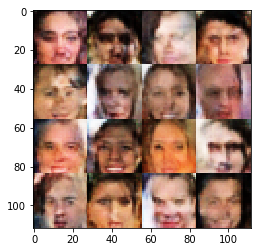

Epoch   1/1   Batch 2410 | Loss: Discriminator = 1.50532, Generator = 0.62625
Epoch   1/1   Batch 2420 | Loss: Discriminator = 1.48203, Generator = 0.69665
Epoch   1/1   Batch 2430 | Loss: Discriminator = 1.36095, Generator = 0.79213
Epoch   1/1   Batch 2440 | Loss: Discriminator = 1.54596, Generator = 0.64409
Epoch   1/1   Batch 2450 | Loss: Discriminator = 1.25466, Generator = 0.86020
Epoch   1/1   Batch 2460 | Loss: Discriminator = 1.51277, Generator = 0.62973
Epoch   1/1   Batch 2470 | Loss: Discriminator = 1.45263, Generator = 0.73483
Epoch   1/1   Batch 2480 | Loss: Discriminator = 1.51171, Generator = 0.62505
Epoch   1/1   Batch 2490 | Loss: Discriminator = 1.35494, Generator = 0.86912
Epoch   1/1   Batch 2500 | Loss: Discriminator = 1.56198, Generator = 0.62460


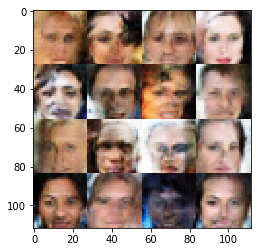

Epoch   1/1   Batch 2510 | Loss: Discriminator = 1.47404, Generator = 0.66155
Epoch   1/1   Batch 2520 | Loss: Discriminator = 1.41046, Generator = 0.66660
Epoch   1/1   Batch 2530 | Loss: Discriminator = 1.60477, Generator = 0.66029
Epoch   1/1   Batch 2540 | Loss: Discriminator = 1.49703, Generator = 0.73893
Epoch   1/1   Batch 2550 | Loss: Discriminator = 1.40200, Generator = 0.74067
Epoch   1/1   Batch 2560 | Loss: Discriminator = 1.44165, Generator = 0.65092
Epoch   1/1   Batch 2570 | Loss: Discriminator = 1.45507, Generator = 0.68086
Epoch   1/1   Batch 2580 | Loss: Discriminator = 1.47355, Generator = 0.63893
Epoch   1/1   Batch 2590 | Loss: Discriminator = 1.51082, Generator = 0.76454
Epoch   1/1   Batch 2600 | Loss: Discriminator = 1.51007, Generator = 0.63803


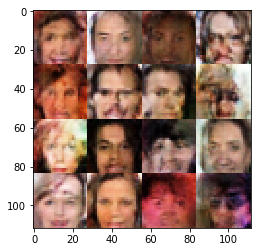

Epoch   1/1   Batch 2610 | Loss: Discriminator = 1.49116, Generator = 0.63777
Epoch   1/1   Batch 2620 | Loss: Discriminator = 1.54140, Generator = 0.60468
Epoch   1/1   Batch 2630 | Loss: Discriminator = 1.47443, Generator = 0.61952
Epoch   1/1   Batch 2640 | Loss: Discriminator = 1.53312, Generator = 0.63493
Epoch   1/1   Batch 2650 | Loss: Discriminator = 1.42850, Generator = 0.70923
Epoch   1/1   Batch 2660 | Loss: Discriminator = 1.48963, Generator = 0.71391
Epoch   1/1   Batch 2670 | Loss: Discriminator = 1.48069, Generator = 0.62775
Epoch   1/1   Batch 2680 | Loss: Discriminator = 1.48669, Generator = 0.68736
Epoch   1/1   Batch 2690 | Loss: Discriminator = 1.49920, Generator = 0.71162
Epoch   1/1   Batch 2700 | Loss: Discriminator = 1.46058, Generator = 0.70789


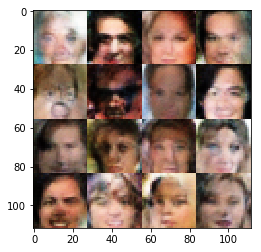

Epoch   1/1   Batch 2710 | Loss: Discriminator = 1.48663, Generator = 0.68823
Epoch   1/1   Batch 2720 | Loss: Discriminator = 1.50962, Generator = 0.58554
Epoch   1/1   Batch 2730 | Loss: Discriminator = 1.50778, Generator = 0.67928
Epoch   1/1   Batch 2740 | Loss: Discriminator = 1.43554, Generator = 0.71528
Epoch   1/1   Batch 2750 | Loss: Discriminator = 1.50384, Generator = 0.62117
Epoch   1/1   Batch 2760 | Loss: Discriminator = 1.50064, Generator = 0.65109
Epoch   1/1   Batch 2770 | Loss: Discriminator = 1.48348, Generator = 0.67509
Epoch   1/1   Batch 2780 | Loss: Discriminator = 1.42794, Generator = 0.66915
Epoch   1/1   Batch 2790 | Loss: Discriminator = 1.52903, Generator = 0.65085
Epoch   1/1   Batch 2800 | Loss: Discriminator = 1.37664, Generator = 0.76759


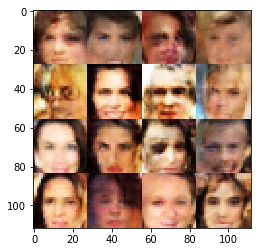

Epoch   1/1   Batch 2810 | Loss: Discriminator = 1.56362, Generator = 0.63384
Epoch   1/1   Batch 2820 | Loss: Discriminator = 1.40850, Generator = 0.66645
Epoch   1/1   Batch 2830 | Loss: Discriminator = 1.43646, Generator = 0.71558
Epoch   1/1   Batch 2840 | Loss: Discriminator = 1.52259, Generator = 0.63435
Epoch   1/1   Batch 2850 | Loss: Discriminator = 1.47768, Generator = 0.64521
Epoch   1/1   Batch 2860 | Loss: Discriminator = 1.42663, Generator = 0.77822
Epoch   1/1   Batch 2870 | Loss: Discriminator = 1.48851, Generator = 0.68141
Epoch   1/1   Batch 2880 | Loss: Discriminator = 1.42090, Generator = 0.72791
Epoch   1/1   Batch 2890 | Loss: Discriminator = 1.50265, Generator = 0.79724
Epoch   1/1   Batch 2900 | Loss: Discriminator = 1.48012, Generator = 0.73826


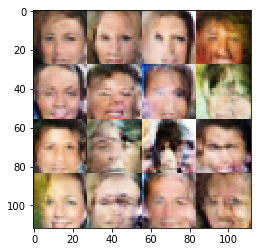

Epoch   1/1   Batch 2910 | Loss: Discriminator = 1.44492, Generator = 0.67480
Epoch   1/1   Batch 2920 | Loss: Discriminator = 1.45340, Generator = 0.72361
Epoch   1/1   Batch 2930 | Loss: Discriminator = 1.50460, Generator = 0.68074
Epoch   1/1   Batch 2940 | Loss: Discriminator = 1.47499, Generator = 0.68311
Epoch   1/1   Batch 2950 | Loss: Discriminator = 1.49298, Generator = 0.69658
Epoch   1/1   Batch 2960 | Loss: Discriminator = 1.43423, Generator = 0.74981
Epoch   1/1   Batch 2970 | Loss: Discriminator = 1.44982, Generator = 0.70183
Epoch   1/1   Batch 2980 | Loss: Discriminator = 1.47905, Generator = 0.66014
Epoch   1/1   Batch 2990 | Loss: Discriminator = 1.42185, Generator = 0.70448
Epoch   1/1   Batch 3000 | Loss: Discriminator = 1.47025, Generator = 0.67185


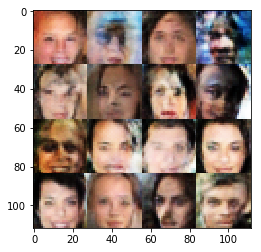

Epoch   1/1   Batch 3010 | Loss: Discriminator = 1.47051, Generator = 0.72070
Epoch   1/1   Batch 3020 | Loss: Discriminator = 1.43053, Generator = 0.67061
Epoch   1/1   Batch 3030 | Loss: Discriminator = 1.52214, Generator = 0.65556
Epoch   1/1   Batch 3040 | Loss: Discriminator = 1.48866, Generator = 0.65561
Epoch   1/1   Batch 3050 | Loss: Discriminator = 1.49267, Generator = 0.67124
Epoch   1/1   Batch 3060 | Loss: Discriminator = 1.44501, Generator = 0.69954
Epoch   1/1   Batch 3070 | Loss: Discriminator = 1.51487, Generator = 0.68231
Epoch   1/1   Batch 3080 | Loss: Discriminator = 1.44825, Generator = 0.65646
Epoch   1/1   Batch 3090 | Loss: Discriminator = 1.48601, Generator = 0.68896
Epoch   1/1   Batch 3100 | Loss: Discriminator = 1.46381, Generator = 0.66092


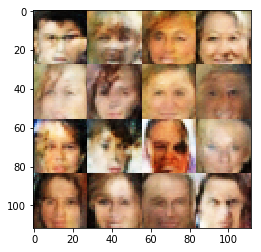

Epoch   1/1   Batch 3110 | Loss: Discriminator = 1.49096, Generator = 0.70431
Epoch   1/1   Batch 3120 | Loss: Discriminator = 1.48267, Generator = 0.72195
Epoch   1/1   Batch 3130 | Loss: Discriminator = 1.45657, Generator = 0.78292
Epoch   1/1   Batch 3140 | Loss: Discriminator = 1.44178, Generator = 0.66619
Epoch   1/1   Batch 3150 | Loss: Discriminator = 1.49905, Generator = 0.68797
Epoch   1/1   Batch 3160 | Loss: Discriminator = 1.49374, Generator = 0.60271


In [22]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.